In [2]:
#Step #1
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras import layers, regularizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, ReLU, Dense, SeparableConv2D, DepthwiseConv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
from keras.optimizers import SGD, Adam
import glob
import multiprocessing as mp
from itertools import repeat
import sys



Using TensorFlow backend.


In [21]:
!pwd

/home/dat/data/Powermetry


In [3]:
def read_xlsx(filename, sheet_name=1):
    return pd.read_excel(filename, sheet_name=sheet_name, verbose=1, parse_dates=True)
def read_raw(basepath):
    list_dir = glob.glob(basepath + "/*.xlsx")
    with mp.Pool(mp.cpu_count()) as p:
        data = p.starmap(read_xlsx, zip(list_dir, repeat(1)))
    return data

In [5]:
# Step 2 Alt: load data from local machine
if sys.platform != 'linux':
    data1 = pd.read_excel(r'D:\Powermetry\data\3nd pack of data\stress_and_CV_experiment_7_Channel_7.1.xlsx', sheet_name='Channel_7_1' ,parse_dates=True)
    # Next step we will load more data
    data2 = pd.read_excel(r'D:\Powermetry\data\3nd pack of data\stress_and_CV_experiment_7_Channel_7.2.xlsx', sheet_name='Channel_7_1', parse_dates=True)
    data3 = pd.read_excel(r'D:\Powermetry\data\3nd pack of data\stress_and_CV_experiment_7_Channel_7.3.xlsx', sheet_name='Channel_7_1', parse_dates=True)
    data4 = pd.read_excel(r'D:\Powermetry\data\3nd pack of data\stress_and_CV_experiment_7_Channel_7.4.xlsx', sheet_name='Channel_7_1', parse_dates=True)
    data5 = pd.read_excel(r'D:\Powermetry\data\3nd pack of data\stress_and_CV_experiment_8_Channel_8.1.xlsx', sheet_name='Channel_8_1', parse_dates=True)
    data6 = pd.read_excel(r'D:\Powermetry\data\3nd pack of data\stress_and_CV_experiment_8_Channel_8.2.xlsx', sheet_name='Channel_8_1', parse_dates=True)
    data7 = pd.read_excel(r'D:\Powermetry\data\3nd pack of data\stress_and_CV_experiment_8_Channel_8.3.xlsx', sheet_name='Channel_8_1', parse_dates=True)
    data8 = pd.read_excel(r'D:\Powermetry\data\3nd pack of data\stress_and_CV_experiment_8_Channel_8.4.xlsx', sheet_name='Channel_8_1', parse_dates=True)
    print("Loading gdrive data done!")
    merged_data = [data1, data2, data3, data4, data5, data6, data7, data8]
else:
  merged_data = read_raw('./data')
  print("Loading gdrive data done!")

Reading sheet 1
Reading sheet 1
Reading sheet 1
Reading sheet 1
Reading sheet 1
Reading sheet 1
Reading sheet 1
Reading sheet 1
Loading gdrive data done!


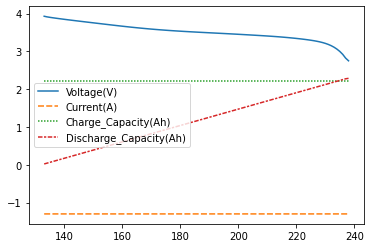

In [6]:
sns.lineplot(data = merged_data[0].groupby(["Step_Index", "Cycle_Index"]).get_group((3,1)).filter(items = ['Voltage(V)', 'Current(A)', 'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)']))

In [ ]:
def data_group_by_cycle_and_step(data, cycle, step):
  return data[(data.Cycle_Index == cycle) & (data.Step_Index == step)]

In [ ]:
#Step #3- Data preprocessing
def preprocess_datum(data):
  x = data[['Voltage(V)', 'Current(A)', 'Charge_Capacity(Ah)', 'Aux_Temperature(℃)_1']].to_numpy()
  y = data[['Discharge_Capacity(Ah)', 'Charge_Capacity(Ah)']].to_numpy()
  temp_x, temp_y = [], []
  for j in range(0,len(x)-25):
    temp_x.append(x[j:j+25])
    temp_y.append(y[int(x[2][j+24] >= 0)][j+25])
  return temp_x, temp_y
def preprocess_data():
  x = []
  y = []
  for i in merged_data:
    for j in range(i.Cycle_Index.max()):
      for k in [1, 2, 3, 4, 5, 6, 7, 8]:
        try:
          print(i)
          temp_x, temp_y = preprocess_datum(data_group_by_cycle_and_step(i, j + 1, k))
          print(len(temp_x))
          x.extend(temp_x)
          y.extend(temp_y)
        except:
          pass
  x = np.array(x)
  y = np.array(y)
  x = x.reshape(x.shape[0],25,4,1)
  print(x.shape, y.shape)
  np.save("/home/dat/data/GDrive/DCNN Powermetry/3nd pack of data/data_x_all_new.npy", x)
  np.save("/home/dat/data/GDrive/DCNN Powermetry/3nd pack of data/data_y_all_new.npy", y)
preprocess_data()

In [ ]:
# load preprocessed data
x = np.load("/home/dat/data/GDrive/DCNN Powermetry/3nd pack of data/data_x_all.npy")
y = np.load("/home/dat/data/GDrive/DCNN Powermetry/3nd pack of data/data_y_all.npy")
# x = np.load("/gdrive/My Drive/DCNN Powermetry/3nd pack of data/data_x.npy")
# y = np.load("/gdrive/My Drive/DCNN Powermetry/3nd pack of data/data_y.npy")


indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
print(x.shape, y.shape)

In [ ]:
def create_model(input_shape, regularizer=None):
  model = Sequential([
                    Conv2D(input_shape=input_shape, filters=16, kernel_size=(1,2), strides=(1,1), padding='same', kernel_regularizer=regularizer),
                    BatchNormalization(axis=1),
                    ReLU(),
                    MaxPooling2D(pool_size=(3,1), strides=(2,1)),
                    Conv2D(filters=32, kernel_size=(3,1), strides=(1,1), padding='same', kernel_regularizer=regularizer),
                    BatchNormalization(axis=1),
                    ReLU(),
                    Conv2D(filters=40, kernel_size=(3,1), strides=(1,1), padding='same', kernel_regularizer=regularizer),
                    BatchNormalization(axis=1),
                    ReLU(),
                    Conv2D(filters=40, kernel_size=(3,1), strides=(1,1), padding='same', kernel_regularizer=regularizer),
                    BatchNormalization(axis=1),
                    ReLU(),
                    Conv2D(filters=40, kernel_size=(3,1), strides=(1,1), padding='same', kernel_regularizer=regularizer),
                    BatchNormalization(axis=1),
                    ReLU(),
                    GlobalAveragePooling2D(),
                    Dense(40, kernel_regularizer=regularizer),
                    BatchNormalization(),
                    ReLU(),
                    Dense(40, kernel_regularizer=regularizer),
                    BatchNormalization(),
                    ReLU(),
                    Dense(1, kernel_regularizer=regularizer)
  ])
  return model

In [ ]:
model = create_model(x.shape[1:])
model.summary()

In [ ]:
sgd = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=sgd, loss='mse')

In [ ]:
history = model.fit(x=x, y=y, validation_split=0.2, epochs=30, batch_size=128, verbose = 1)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.ylim([0,0.4])
plt.show()

In [ ]:
def check_interval(cycle, step):
  test_time_sum = 0
  step_time_sum = 0
  n = 1e-9
  groupby = data1[(data1.Cycle_Index == cycle) & (data1.Step_Index == step)]
  step_time = groupby["Step_Time(s)"].to_numpy()
  test_time = groupby["Test_Time(s)"].to_numpy()
  for i in range(1, len(step_time)):
    n += 1
    test_time_sum += (test_time[i] - test_time[i-1])
    step_time_sum += (step_time[i] - step_time[i-1])
  #print(n)
  return test_time_sum / n, step_time_sum / n
interval_test_time = []
interval_step_time = []
for i in range(data1.Cycle_Index.max()):
  temp1 = []
  temp2 = []
  for j in range(data1.Step_Index.max()):
    # if j == 6:
    #   continue
    # if j in [5,6,7] and i == 56:
    #   continue
    try:
      test_time_mean, step_time_mean = check_interval(i+1, j+1)
      temp1.append(test_time_mean)
      temp2.append(step_time_mean)
    except Exception as e:
      # print("Cycle ", i+1, " Step ", j+1)
      print(e)
      temp1.append(-1)
      temp2.append(-1)
  interval_test_time.append(temp1)
  interval_step_time.append(temp2)
interval_test_time = np.array(interval_test_time)
interval_step_time = np.array(interval_step_time)

In [ ]:
step_index = 7
print(interval_test_time[0,:])
print(interval_step_time[0,:])

In [ ]:
from scipy.io import loadmat
temp = loadmat("/GDrive/DCNN Powermetry/public_data/B0005.mat", squeeze_me=True)

In [ ]:
cycle = temp['B0005']['cycle']
cycle.item()[0][3].dtype